In [ ]:
#!pip install pybaseball
#!pip install iterative-stratification

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pybaseball import  playerid_lookup, statcast_pitcher, pitching_stats
import datetime as dt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Masking, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
from keras_tuner import RandomSearch
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import re
import time
from datetime import timedelta
from pandas.errors import ParserError
from pybaseball import statcast, playerid_lookup


2025-08-13 17:19:48.864447: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Grabbing pitch by pitch data for all pitchers with minimum qualifying innings
pitchers_2025 = pitching_stats(2025)
pitchers_2025[['first', 'last']] = pitchers_2025['Name'].str.split(' ', n=1, expand=True)
pitchers_2025['first'] = pitchers_2025['first'].str.lower()
pitchers_2025['last'] = pitchers_2025['last'].str.lower()

player_ids = []

for _, row in pitchers_2025.iterrows():
    try:
        info = playerid_lookup(row['last'], row['first'])  # Note: last name first
        if not info.empty:
            # Sort if multiple results, and grab just the top one
            mlbam_id = info.sort_values(by='key_mlbam', ascending=False).iloc[0]['key_mlbam']
            player_ids.append(int(mlbam_id))
    except Exception as e:
        print(f"Error for {row['Name']}: {e}")
        continue

start_date = "2025-02-18"
end_date = "2025-08-10"  # today's date

all_pitch_data = []

for pid in player_ids:
    try:
        data = statcast_pitcher(start_date, end_date, pid)
        if not data.empty:
            all_pitch_data.append(data)
    except Exception as e:
        print(f"Error for pitcher {pid}: {e}")
        continue

# Combine all into one DataFrame
combined_pitch_data = pd.concat(all_pitch_data, ignore_index=True)
combined_pitch_data

Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,FF,2025-08-08,97.3,1.58,6.17,"Skubal, Tarik",545361,669373,single,hit_into_play,...,1.0,1.15,0.16,-0.16,51.9,-11.102907,22.129886,42.019613,25.119396,13.102859
1,FF,2025-08-08,98.4,1.52,6.06,"Skubal, Tarik",545361,669373,NaN,ball,...,1.0,1.06,0.24,-0.24,49.3,NaN,NaN,NaN,NaN,NaN
2,CH,2025-08-08,86.9,1.93,5.97,"Skubal, Tarik",545361,669373,NaN,called_strike,...,1.0,2.89,1.11,-1.11,44.0,NaN,NaN,NaN,NaN,NaN
3,SI,2025-08-08,95.6,1.78,6.00,"Skubal, Tarik",545361,669373,NaN,called_strike,...,1.0,1.51,1.21,-1.21,50.2,NaN,NaN,NaN,NaN,NaN
4,CH,2025-08-08,87.6,1.77,5.95,"Skubal, Tarik",694384,669373,strikeout,swinging_strike,...,1.0,2.88,1.18,1.18,44.8,25.711936,-33.439543,39.090048,32.316161,48.770735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123520,NaN,2025-02-26,NaN,NaN,NaN,"Anderson, Tyler",682829,542881,NaN,ball,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123521,NaN,2025-02-26,NaN,NaN,NaN,"Anderson, Tyler",666158,542881,field_out,hit_into_play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123522,NaN,2025-02-26,NaN,NaN,NaN,"Anderson, Tyler",680574,542881,double,hit_into_play,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123523,NaN,2025-02-26,NaN,NaN,NaN,"Anderson, Tyler",680574,542881,NaN,swinging_strike,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
columns_to_keep = [
    ## Pitcher + pitch identity
    'player_name', 'pitch_type', 'pitch_number', 'at_bat_number', 'game_pk',
    'batter', 'pitcher', 'stand', 'p_throws',

    ## Pitch physics
    'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z',
    'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'plate_x', 'plate_z', 'sz_top', 'sz_bot',

    ## Count / game state
    'balls', 'strikes', 'outs_when_up', 'inning', 'inning_topbot',
    'bat_score', 'fld_score',

    ## Runners on base
    'on_1b', 'on_2b', 'on_3b',

    ## Score context
    'home_score', 'away_score', 'home_score_diff', 'bat_score_diff',

    ## Strategy / sequencing dynamics
    'n_thruorder_pitcher',
    'n_priorpa_thisgame_player_at_bat',

    ## Outcome labels (still useful for filtering)
    'description', 'events'
]


pitch_data = combined_pitch_data[columns_to_keep]
pitch_data

,player_name,pitch_type,pitch_number,at_bat_number,game_pk,batter,pitcher,stand,p_throws,release_speed,...,on_2b,on_3b,home_score,away_score,home_score_diff,bat_score_diff,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,description,events
0,"Skubal, Tarik",FF,4,39,776832,545361,669373,R,L,97.3,...,NaN,NaN,3,4,-1,1,3,2,hit_into_play,single
1,"Skubal, Tarik",FF,3,39,776832,545361,669373,R,L,98.4,...,NaN,NaN,3,4,-1,1,3,2,ball,NaN
2,"Skubal, Tarik",CH,2,39,776832,545361,669373,R,L,86.9,...,NaN,NaN,3,4,-1,1,3,2,called_strike,NaN
3,"Skubal, Tarik",SI,1,39,776832,545361,669373,R,L,95.6,...,NaN,NaN,3,4,-1,1,3,2,called_strike,NaN
4,"Skubal, Tarik",CH,4,38,776832,694384,669373,L,L,87.6,...,NaN,NaN,3,4,-1,1,3,2,swinging_strike,strikeout
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123520,"Anderson, Tyler",NaN,1,3,779160,682829,542881,R,L,NaN,...,680574.0,NaN,0,0,0,0,1,0,ball,NaN
123521,"Anderson, Tyler",NaN,1,2,779160,666158,542881,L,L,NaN,...,680574.0,NaN,0,0,0,0,1,0,hit_into_play,field_out
123522,"Anderson, Tyler",NaN,3,1,779160,680574,542881,R,L,NaN,...,NaN,NaN,0,0,0,0,1,0,hit_into_play,double
123523,"Anderson, Tyler",NaN,2,1,779160,680574,542881,R,L,NaN,...,NaN,NaN,0,0,0,0,1,0,swinging_strike,NaN


In [4]:
## Imputing NaN for events because it means the batter is still up
pitch_data.loc[:, 'events'] = pitch_data['events'].fillna('batter still up')

pitch_data.loc[:, 'runner_on_1b'] = pitch_data['on_1b'].notna().astype(int)
pitch_data.loc[:, 'runner_on_2b'] = pitch_data['on_2b'].notna().astype(int)
pitch_data.loc[:, 'runner_on_3b'] = pitch_data['on_3b'].notna().astype(int)

pitch_data.drop(columns=['on_1b', 'on_2b', 'on_3b'], inplace=True)



/var/folders/82/cfm89vg521n6ydcbprwxcw3w0000gn/T/ipykernel_68889/1589671432.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_data.loc[:, 'runner_on_1b'] = pitch_data['on_1b'].notna().astype(int)
/var/folders/82/cfm89vg521n6ydcbprwxcw3w0000gn/T/ipykernel_68889/1589671432.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitch_data.loc[:, 'runner_on_2b'] = pitch_data['on_2b'].notna().astype(int)
/var/folders/82/cfm89vg521n6ydcbprwxcw3w0000gn/T/ipykernel_68889/1589671432.py:6: SettingWithCopyWarning

In [5]:
## Adding sequencing IDs
pitch_data = pitch_data.copy()

pitch_data['sequence_id'] = (
    pitch_data.groupby(['game_pk', 'at_bat_number']).ngroup()
)

pitch_data['pitch_number'] = (
    pitch_data.groupby('sequence_id').cumcount() + 1
)

In [6]:
pitch_data

,player_name,pitch_type,pitch_number,at_bat_number,game_pk,batter,pitcher,stand,p_throws,release_speed,...,home_score_diff,bat_score_diff,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,description,events,runner_on_1b,runner_on_2b,runner_on_3b,sequence_id
0,"Skubal, Tarik",FF,1,39,776832,545361,669373,R,L,97.3,...,-1,1,3,2,hit_into_play,single,0,0,0,567
1,"Skubal, Tarik",FF,2,39,776832,545361,669373,R,L,98.4,...,-1,1,3,2,ball,batter still up,0,0,0,567
2,"Skubal, Tarik",CH,3,39,776832,545361,669373,R,L,86.9,...,-1,1,3,2,called_strike,batter still up,0,0,0,567
3,"Skubal, Tarik",SI,4,39,776832,545361,669373,R,L,95.6,...,-1,1,3,2,called_strike,batter still up,0,0,0,567
4,"Skubal, Tarik",CH,1,38,776832,694384,669373,L,L,87.6,...,-1,1,3,2,swinging_strike,strikeout,0,0,0,566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123520,"Anderson, Tyler",NaN,5,3,779160,682829,542881,R,L,NaN,...,0,0,1,0,ball,batter still up,0,1,0,31675
123521,"Anderson, Tyler",NaN,1,2,779160,666158,542881,L,L,NaN,...,0,0,1,0,hit_into_play,field_out,0,1,0,31674
123522,"Anderson, Tyler",NaN,1,1,779160,680574,542881,R,L,NaN,...,0,0,1,0,hit_into_play,double,0,0,0,31673
123523,"Anderson, Tyler",NaN,2,1,779160,680574,542881,R,L,NaN,...,0,0,1,0,swinging_strike,batter still up,0,0,0,31673


In [7]:
pitch_data.isna().sum()

player_name                            0
pitch_type                          4595
pitch_number                           0
at_bat_number                          0
game_pk                                0
batter                                 0
pitcher                                0
stand                                  0
p_throws                               0
release_speed                       4601
release_pos_x                       4601
release_pos_y                       4601
release_pos_z                       4601
release_spin_rate                   5068
spin_axis                           5069
pfx_x                               4734
pfx_z                               4601
plate_x                             4601
plate_z                             4601
sz_top                              4601
sz_bot                              4601
balls                                  0
strikes                                0
outs_when_up                           0
inning          

In [8]:
## Dealing with missing data
critical_columns = ['pitch_type', 'release_speed', 'plate_x', 'plate_z', 'release_pos_x', 'release_pos_y', 'release_pos_z', 
'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'sz_top', 'sz_bot']

# Step 1: Find sequence_ids with ANY missing value in those columns
sequences_with_na = (
    pitch_data[critical_columns + ['sequence_id']]
    .groupby('sequence_id')
    .apply(lambda df: df[critical_columns].isnull().any().any())
)

# Step 2: Get only the sequence_ids with missing values
bad_sequences = sequences_with_na[sequences_with_na].index.tolist()

# Step 3: Filter out those sequences
pitch_data_cleaned = pitch_data[~pitch_data['sequence_id'].isin(bad_sequences)].copy()

/var/folders/82/cfm89vg521n6ydcbprwxcw3w0000gn/T/ipykernel_68889/1683873461.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df[critical_columns].isnull().any().any())


In [9]:
pitch_data_cleaned.isna().sum()

player_name                         0
pitch_type                          0
pitch_number                        0
at_bat_number                       0
game_pk                             0
batter                              0
pitcher                             0
stand                               0
p_throws                            0
release_speed                       0
release_pos_x                       0
release_pos_y                       0
release_pos_z                       0
release_spin_rate                   0
spin_axis                           0
pfx_x                               0
pfx_z                               0
plate_x                             0
plate_z                             0
sz_top                              0
sz_bot                              0
balls                               0
strikes                             0
outs_when_up                        0
inning                              0
inning_topbot                       0
bat_score   

## Feature Engineering

### One-Hot Encoding

In [10]:
columns_to_encode = ['inning_topbot', 'stand', 'p_throws']
def one_hot_encode (data, columns):
  for column in columns:
    data = pd.get_dummies(data, columns=[column], dtype=int)
  return data

pitch_data_encoded = one_hot_encode(pitch_data_cleaned, columns_to_encode)

In [ ]:

pitch_types = pitch_data_encoded['pitch_type'] 

## Initialize the label encoder
le = LabelEncoder()

## Fit the encoder and transform the pitch type strings to integers
pitch_data_encoded['pitch_type_encoded'] = le.fit_transform(pitch_types)

## Saving the mapping from pitch type string to integer
pitch_type_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print("Pitch type mapping:", pitch_type_mapping)

## 'pitch_type_encoded' is an integer column ready for model training
pitch_data_encoded = pitch_data_encoded.copy().drop(columns = ['pitch_type'])
pitch_data_encoded


Pitch type mapping: {'CH': 0, 'CS': 1, 'CU': 2, 'FC': 3, 'FF': 4, 'FS': 5, 'KC': 6, 'PO': 7, 'SI': 8, 'SL': 9, 'ST': 10, 'SV': 11}


,player_name,pitch_number,at_bat_number,game_pk,batter,pitcher,release_speed,release_pos_x,release_pos_y,release_pos_z,...,runner_on_2b,runner_on_3b,sequence_id,inning_topbot_Bot,inning_topbot_Top,stand_L,stand_R,p_throws_L,p_throws_R,pitch_type_encoded
0,"Skubal, Tarik",1,39,776832,545361,669373,97.3,1.58,54.03,6.17,...,0,0,567,0,1,0,1,1,0,4
1,"Skubal, Tarik",2,39,776832,545361,669373,98.4,1.52,53.95,6.06,...,0,0,567,0,1,0,1,1,0,4
2,"Skubal, Tarik",3,39,776832,545361,669373,86.9,1.93,54.22,5.97,...,0,0,567,0,1,0,1,1,0,0
3,"Skubal, Tarik",4,39,776832,545361,669373,95.6,1.78,53.96,6.00,...,0,0,567,0,1,0,1,1,0,8
4,"Skubal, Tarik",1,38,776832,694384,669373,87.6,1.77,54.06,5.95,...,0,0,566,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123222,"Anderson, Tyler",3,6,778503,575929,542881,88.0,1.47,54.56,6.45,...,0,0,27428,1,0,0,1,1,0,4
123223,"Anderson, Tyler",1,5,778503,663457,542881,76.8,1.52,54.55,6.57,...,0,0,27427,1,0,1,0,1,0,0
123224,"Anderson, Tyler",2,5,778503,663457,542881,83.3,1.77,54.56,6.31,...,0,0,27427,1,0,1,0,1,0,3
123225,"Anderson, Tyler",3,5,778503,663457,542881,88.1,1.31,54.36,6.36,...,0,0,27427,1,0,1,0,1,0,4


### Column Dropping

In [12]:
columns_to_drop = ['game_pk', 'pitcher', 'at_bat_number', 'bat_score', 'fld_score', 'events', 'description']
pitch = pitch_data_encoded.drop(columns = columns_to_drop)

### Normalizing Data

In [ ]:
non_numeric_cols = pitch.select_dtypes(include=['object', 'category']).columns.tolist()

## Specify non-scaled columns explicitly
non_scaled_cols = ['pitch_number', 'sequence_id', 'player_name', 'pitch_type_encoded']

## Columns to exclude from scaling
all_excluded_cols = list(set(non_scaled_cols + non_numeric_cols))

## Scale only numeric columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pitch.drop(columns=all_excluded_cols))

## Convert scaled values to DataFrame
scaled_df = pd.DataFrame(scaled_features, 
                         columns=pitch.drop(columns=all_excluded_cols).columns,
                         index=pitch.index)

## Reattach excluded (non-scaled) columns
pitch_scaled = pd.concat([scaled_df, pitch[all_excluded_cols]], axis=1)
cols = ['sequence_id', 'pitch_number', 'player_name'] + [col for col in pitch_scaled.columns if col not in ['sequence_id', 'pitch_number']]
pitch_scaled = pitch_scaled[cols]
pitch_scaled


,sequence_id,pitch_number,player_name,batter,release_speed,release_pos_x,release_pos_y,release_pos_z,release_spin_rate,spin_axis,...,runner_on_2b,runner_on_3b,inning_topbot_Bot,inning_topbot_Top,stand_L,stand_R,p_throws_L,p_throws_R,pitch_type_encoded,player_name
0,567,1,"Skubal, Tarik",-2.129812,1.373089,1.223645,0.105965,0.852942,0.100380,-0.329293,...,-0.434054,-0.282173,-0.963564,0.963564,-0.875560,0.875560,1.587518,-1.587518,4,"Skubal, Tarik"
1,567,2,"Skubal, Tarik",-2.129812,1.560861,1.192427,-0.090854,0.613356,-0.025119,-0.357292,...,-0.434054,-0.282173,-0.963564,0.963564,-0.875560,0.875560,1.587518,-1.587518,4,"Skubal, Tarik"
2,567,3,"Skubal, Tarik",-2.129812,-0.402210,1.405747,0.573410,0.417331,-2.118670,-0.553281,...,-0.434054,-0.282173,-0.963564,0.963564,-0.875560,0.875560,1.587518,-1.587518,0,"Skubal, Tarik"
3,567,4,"Skubal, Tarik",-2.129812,1.082896,1.327703,-0.066252,0.482673,-0.313196,-0.329293,...,-0.434054,-0.282173,-0.963564,0.963564,-0.875560,0.875560,1.587518,-1.587518,8,"Skubal, Tarik"
4,566,1,"Skubal, Tarik",0.818188,-0.282719,1.322500,0.179772,0.373770,-1.824889,-0.581280,...,-0.434054,-0.282173,-0.963564,0.963564,1.142126,-1.142126,1.587518,-1.587518,0,"Skubal, Tarik"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123222,27428,3,"Anderson, Tyler",-1.525111,-0.214438,1.166413,1.409891,1.462798,-0.501445,-0.217299,...,-0.434054,-0.282173,1.037814,-1.037814,-0.875560,0.875560,1.587518,-1.587518,4,"Anderson, Tyler"
123223,27427,1,"Anderson, Tyler",0.206384,-2.126298,1.192427,1.385288,1.724164,-0.983475,-0.567280,...,-0.434054,-0.282173,1.037814,-1.037814,1.142126,-1.142126,1.587518,-1.587518,0,"Anderson, Tyler"
123224,27427,2,"Anderson, Tyler",0.206384,-1.016736,1.322500,1.409891,1.157870,-0.045085,-0.273296,...,-0.434054,-0.282173,1.037814,-1.037814,1.142126,-1.142126,1.587518,-1.587518,3,"Anderson, Tyler"
123225,27427,3,"Anderson, Tyler",0.206384,-0.197368,1.083166,0.917843,1.266773,-0.267560,-0.301295,...,-0.434054,-0.282173,1.037814,-1.037814,1.142126,-1.142126,1.587518,-1.587518,4,"Anderson, Tyler"


In [14]:
pitch_final = pitch_scaled.copy()

In [15]:
pitch_final = pitch_final.loc[:, ~pitch_final.columns.duplicated()]
pitch_final['player_name']

0           Skubal, Tarik
1           Skubal, Tarik
2           Skubal, Tarik
3           Skubal, Tarik
4           Skubal, Tarik
               ...       
123222    Anderson, Tyler
123223    Anderson, Tyler
123224    Anderson, Tyler
123225    Anderson, Tyler
123226    Anderson, Tyler
Name: player_name, Length: 118170, dtype: object

In [ ]:
## Step 1: Group sequences by (pitcher, sequence), ordered by pitch_number
grouped = pitch_final.sort_values(['sequence_id', 'pitch_number']).groupby(['player_name', 'sequence_id'])
pitcher_to_sequences = defaultdict(list)

for (pitcher, sequence_id), group in grouped:
    pitcher_to_sequences[pitcher].append((sequence_id, group))

## Step 2: Initializing storage
X_train_final, y_train_final, train_pitcher_ids = [], [], []
X_val, y_val, val_pitcher_ids = [], [], []
X_test, y_test, test_pitcher_ids = [], [], []

## Step 3: Per-pitcher split into train/val/test
for pitcher, seq_data in pitcher_to_sequences.items():
    if len(seq_data) < 3:  # Skip pitchers with too few sequences
        continue

    # Split: 64% train, 16% val, 20% test
    train_seqs, temp_seqs = train_test_split(seq_data, test_size=0.36, random_state=42)
    val_seqs, test_seqs = train_test_split(temp_seqs, test_size=5/9, random_state=42)  # ≈ 0.16 val, 0.20 test

    def extract_sequences(seqs, X_bucket, y_bucket, pid_bucket):
        for _, group in seqs:
            pitches = group['pitch_type_encoded'].tolist()
            for i in range(1, len(pitches)):
                X_bucket.append(pitches[:i])
                y_bucket.append(pitches[i])
                pid_bucket.append(pitcher)

    extract_sequences(train_seqs, X_train_final, y_train_final, train_pitcher_ids)
    extract_sequences(val_seqs, X_val, y_val, val_pitcher_ids)
    extract_sequences(test_seqs, X_test, y_test, test_pitcher_ids)



In [ ]:
## FILTERING SHORT SEQUENCES (≥ 3 pitches)
X_train_final, y_train_final, train_pitcher_ids = zip(*[
    (x, y, p) for x, y, p in zip(X_train_final, y_train_final, train_pitcher_ids) if len(x) >= 3
])
X_val, y_val, val_pitcher_ids = zip(*[
    (x, y, p) for x, y, p in zip(X_val, y_val, val_pitcher_ids) if len(x) >= 3
])
X_test, y_test, test_pitcher_ids = zip(*[
    (x, y, p) for x, y, p in zip(X_test, y_test, test_pitcher_ids) if len(x) >= 3
])



In [18]:
## Padding sequences
max_len = max(len(seq) for seq in X_train_final)

X_train_pad = pad_sequences(X_train_final, padding='pre', maxlen=max_len)
X_val_pad = pad_sequences(X_val, padding='pre', maxlen=max_len)
X_test_pad = pad_sequences(X_test, padding='pre', maxlen=max_len)

y_train_arr = np.array(y_train_final)
y_val_arr = np.array(y_val)
y_test_arr = np.array(y_test)

vocab_size = np.max(y_train_arr) + 1  # or len(np.unique(y_train_arr))



## Modeling

In [ ]:
vocab_size = np.max(y_train_arr) + 1  
input_length = X_train_pad.shape[1]

def build_model(hp):
    model = Sequential()
    
    ## Embedding with masking
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', min_value=32, max_value=64, step=16),
        mask_zero=True
    ))
    
    ## First GRU layer returns sequences so I can stack another
    model.add(Bidirectional(GRU(
        units=hp.Int('gru_units_1', min_value=64, max_value=128, step=32),
        return_sequences=True,
        dropout=hp.Float('dropout_1', 0.2, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_1', 0.1, 0.5, step=0.1)
    )))

    ## Second GRU layer processes the sequence
    model.add(Bidirectional(GRU(
        units=hp.Int('gru_units_2', min_value=32, max_value=64, step=16),
        return_sequences=False,
        dropout=hp.Float('dropout_2', 0.2, 0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout_2', 0.1, 0.5, step=0.1)
    )))
    
    ## Dense hidden layer before output
    model.add(Dense(
        hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dense_dropout', 0.2, 0.5, step=0.1)))
    
    ## Output layer
    model.add(Dense(vocab_size, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
## Initializing tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='pitch_sequence_tuning',
    project_name='gru_rnn_random_v2',
    overwrite=True,
    seed=42
)


In [21]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=2, min_lr=1e-5, verbose=1)

early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(X_train_pad, y_train_arr,
             validation_data=(X_val_pad, y_val_arr),
             epochs=10,
             batch_size=32,
             callbacks=[early_stop_cb, lr_scheduler])


Trial 5 Complete [00h 05m 35s]
val_accuracy: 0.38135191798210144

Best val_accuracy So Far: 0.3848345875740051
Total elapsed time: 00h 24m 49s


In [22]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

/opt/anaconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Testing on pitchers

In [23]:
pitcher_scores = {}

for pitcher in set(test_pitcher_ids):
    indices = [i for i, pid in enumerate(test_pitcher_ids) if pid == pitcher]
    if not indices:
        continue

    X_p = X_test_pad[indices]
    y_p = y_test_arr[indices]

    loss, acc = best_model.evaluate(X_p, y_p, verbose=0)
    num_pitch_types = len(np.unique(y_p))

    if num_pitch_types > 1:  # avoid divide-by-zero or meaningless 1-pitch cases
        random_baseline = 1 / num_pitch_types
        predictability_score = (acc - random_baseline) / (1 - random_baseline)
    else:
        predictability_score = 0  # or np.nan

    pitcher_scores[pitcher] = {
        'test_accuracy': acc,
        'num_pitch_types': num_pitch_types,
        'predictability_score': predictability_score
    }

predictability_df = pd.DataFrame.from_dict(pitcher_scores, orient='index')
predictability_df = predictability_df.sort_values("predictability_score", ascending=False)
predictability_df.reset_index(inplace=True)
predictability_df.rename(columns={"index": "pitcher_name"}, inplace=True)


In [24]:
predictability_df.sort_values(by='predictability_score', ascending=False)

,pitcher_name,test_accuracy,num_pitch_types,predictability_score
0,"Pepiot, Ryan",0.544776,6,0.453731
1,"Ryan, Joe",0.540000,6,0.448000
2,"Gore, MacKenzie",0.542857,5,0.428571
3,"Cease, Dylan",0.512500,6,0.415000
4,"Brown, Hunter",0.508876,6,0.410651
5,"Baz, Shane",0.523179,5,0.403974
6,"Peralta, Freddy",0.540698,4,0.387597
7,"Gallen, Zac",0.488372,6,0.386047
8,"Parker, Mitchell",0.529412,4,0.372549
9,"Ray, Robbie",0.493976,5,0.367470


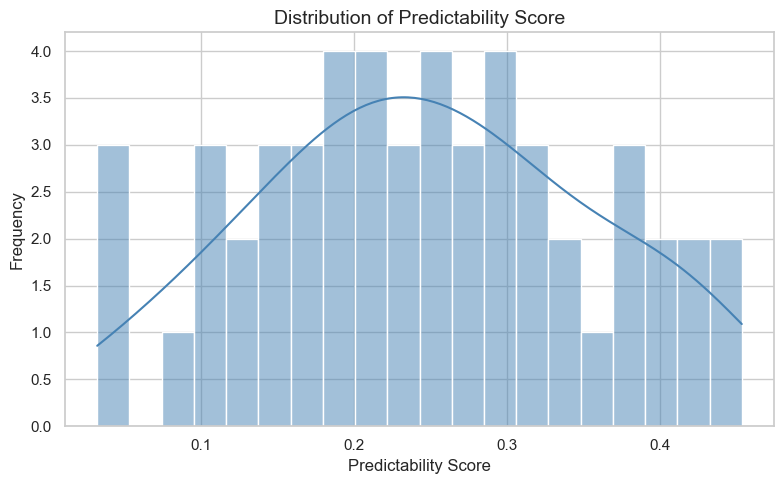

In [ ]:
## Set a consistent style
sns.set(style="whitegrid", palette="muted")

## Histogram of predictability_score
plt.figure(figsize=(8, 5))
sns.histplot(predictability_df['predictability_score'], bins=20, kde=True, color='steelblue')
plt.title('Distribution of Predictability Score', fontsize=14)
plt.xlabel('Predictability Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show();

/var/folders/82/cfm89vg521n6ydcbprwxcw3w0000gn/T/ipykernel_68889/1570620204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='num_pitch_types', y='predictability_score', data=predictability_df, palette="Set2")


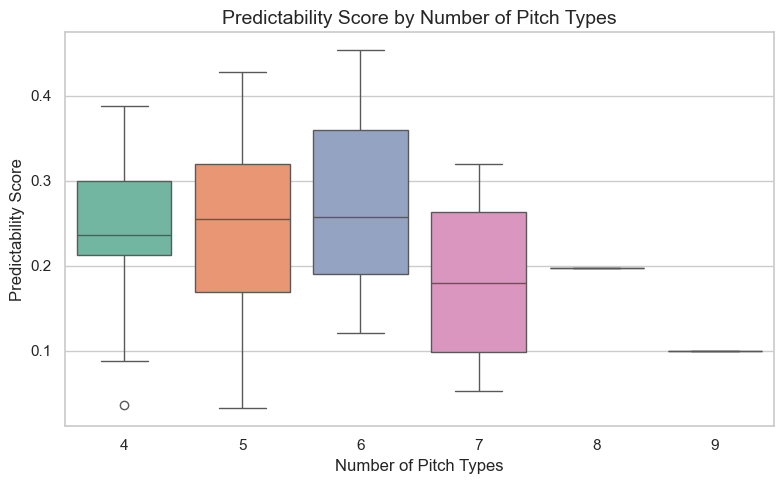

In [26]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='num_pitch_types', y='predictability_score', data=predictability_df, palette="Set2")
plt.title('Predictability Score by Number of Pitch Types', fontsize=14)
plt.xlabel('Number of Pitch Types', fontsize=12)
plt.ylabel('Predictability Score', fontsize=12)
plt.tight_layout()
plt.show();

In [ ]:
## Configuring winodow to get Statcast metrics
start_date = "2025-02-18"
end_date   = "2025-08-10"
WINDOW_DAYS = 7  # chunk size for Statcast pulls

## Helper functions

# Normalizaed Accuracy Gain (NAG) calculation for preditability score
def nag_uniform(acc: float, k: int) -> float:
    """Normalized Accuracy Gain with a uniform (1/k) baseline."""
    if k is None or k < 2 or acc is None or not (0.0 <= acc <= 1.0):
        return np.nan
    base = 1.0 / k
    return (acc - base) / (1.0 - base)

SUFFIXES = {"jr", "sr", "ii", "iii", "iv", "v"}

## Cleaning names
def clean_suffixes(s: str) -> str:
    s = re.sub(r"[^\w\s\-',]", " ", str(s)).strip()
    parts = [p for p in s.replace(".", "").split() if p.lower() not in SUFFIXES]
    return " ".join(parts)

## Parsing names
def parse_name(raw: str):
    """Return (first, last) from 'Last, First' or 'First Last'."""
    s = clean_suffixes(raw)
    if "," in s:  # "Last, First"
        last, first = [p.strip() for p in s.split(",", 1)]
        return first, last
    toks = s.split()
    if len(toks) == 1:
        return toks[0], ""
    return toks[0], " ".join(toks[1:])

## Selecting best candidate from playerid_lookup results, just in case one is not found
def best_candidate(df: pd.DataFrame):
    """Pick a likely MLBAM id from playerid_lookup results."""
    if df is None or df.empty:
        return None
    for col in ["mlb_played_last", "mlb_played_first", "key_mlbam"]:
        if col not in df.columns:
            df[col] = np.nan
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.sort_values(
        ["mlb_played_last", "mlb_played_first", "key_mlbam"],
        ascending=[False, False, False],
        kind="mergesort"
    )
    val = df.iloc[0]["key_mlbam"]
    return int(val) if pd.notna(val) else None

## ID lookup function
def lookup_mlbam_id(name: str):
    """Lookup MLBAM id from a name string."""
    first, last = parse_name(name)
    if not first and not last:
        return None
    for L, R in [
        (last, first),
        (last.split()[-1] if last else "", first),
        (first, last),
    ]:
        try:
            c = playerid_lookup(L, R)
            pid = best_candidate(c)
            if pid:
                return pid
        except Exception:
            pass
    return None

## Chunked Statcast pull with retry/backoff
def statcast_all_safe(start_date, end_date, window_days=7, max_retries=3, backoff=1.6):
    """Chunked Statcast pull with simple retry/backoff."""
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    frames = []
    cur = start
    while cur <= end:
        chunk_start = cur
        chunk_end = min(cur + timedelta(days=window_days - 1), end)
        tries = 0
        while tries < max_retries:
            try:
                df = statcast(chunk_start.strftime("%Y-%m-%d"),
                              chunk_end.strftime("%Y-%m-%d"))
                if df is not None and not df.empty:
                    frames.append(df)
                break
            except (ParserError, ValueError) as e:
                tries += 1
                wait = backoff ** (tries - 1)
                print(f"[statcast] parse error {chunk_start:%Y-%m-%d}–{chunk_end:%Y-%m-%d}; "
                      f"retry {tries}/{max_retries} in {wait:.1f}s ({e})")
                time.sleep(wait)
            except Exception as e:
                tries += 1
                wait = backoff ** (tries - 1)
                print(f"[statcast] {type(e).__name__}: {e}; retry {tries}/{max_retries} in {wait:.1f}s")
                time.sleep(wait)
        cur = chunk_end + timedelta(days=1)

    if not frames:
        return pd.DataFrame()
    out = pd.concat(frames, ignore_index=True)
    if "pitcher" in out.columns:
        out["pitcher"] = pd.to_numeric(out["pitcher"], errors="coerce").astype("Int64")
    return out

## Computing barrel mask
def compute_barrel_mask(ev: pd.Series, la: pd.Series) -> pd.Series:
    """EV/LA band per Statcast-style heuristic (no need for a precomputed 'barrel' flag)."""
    ev = pd.to_numeric(ev, errors="coerce")
    la = pd.to_numeric(la, errors="coerce")
    mask_ev = ev >= 98
    min_la = np.maximum(26 - (ev - 98), 8)
    max_la = np.minimum(30 + (ev - 98), 50)
    mask_la = (la >= min_la) & (la <= max_la)
    return mask_ev & mask_la

# ==== BUILDING pred_metrics_df FROM predictability_df ===========================
# Expect predictability_df to have: pitcher_name, num_pitch_types, test_accuracy
if 'predictability_df' not in globals():
    raise NameError("`predictability_df` not found. Create it first, then run this cell.")

pred_metrics_df = predictability_df.copy()

## Compute NAG (uniform baseline) as your predictability score
required = {'pitcher_name', 'num_pitch_types', 'test_accuracy'}
missing = required - set(pred_metrics_df.columns)
if missing:
    raise KeyError(f"predictability_df missing required columns: {missing}")

pred_metrics_df["predictability_score"] = [
    nag_uniform(a, k) for a, k in zip(pred_metrics_df["test_accuracy"],
                                      pred_metrics_df["num_pitch_types"])
]

## Map pitcher_name -> mlbam_id (for merging Statcast metrics)
pred_metrics_df["mlbam_id"] = (
    pred_metrics_df["pitcher_name"]
    .astype(str)
    .map(lambda nm: lookup_mlbam_id(nm))
).astype("Int64")

# ==== STATCAST METRICS FOR THE DATE WINDOW ===================================
print(f"[info] downloading Statcast for {start_date} → {end_date} (window={WINDOW_DAYS}d)")
sc_all = statcast_all_safe(start_date, end_date, window_days=WINDOW_DAYS)

if not sc_all.empty:
    ## Contact-only rows for contact-quality metrics
    bbe_mask = sc_all.get("type").eq("X") if "type" in sc_all.columns else pd.Series(False, index=sc_all.index)
    bbe_df = sc_all.loc[bbe_mask].copy()

    ## xwOBA against on contact
    if "estimated_woba_using_speedangle" in bbe_df.columns:
        xw = (bbe_df.groupby("pitcher")["estimated_woba_using_speedangle"]
              .mean().rename("xwoba_against"))
    else:
        xw = pd.Series(dtype=float, name="xwoba_against")

    ## Barrel% against via EV/LA band
    if {"launch_speed", "launch_angle"}.issubset(bbe_df.columns):
        bbe_df["_barrel"] = compute_barrel_mask(bbe_df["launch_speed"], bbe_df["launch_angle"])
        barrel_pct = (bbe_df.groupby("pitcher")["_barrel"].mean().mul(100.0)
                      .rename("barrel_percent_against"))
    else:
        barrel_pct = pd.Series(dtype=float, name="barrel_percent_against")

    metrics = (pd.concat([xw, barrel_pct], axis=1)
                 .reset_index()
                 .rename(columns={"pitcher": "mlbam_id"}))
else:
    metrics = pd.DataFrame(columns=["mlbam_id", "xwoba_against", "barrel_percent_against"])

## Round/clean
for c, nd in [("xwoba_against", 6), ("barrel_percent_against", 3)]:
    if c in metrics.columns:
        metrics[c] = pd.to_numeric(metrics[c], errors="coerce").round(nd)

# ==== MERGE METRICS INTO pred_metrics_df =====================================
for c in ["xwoba_against", "barrel_percent_against"]:
    if c not in pred_metrics_df.columns:
        pred_metrics_df[c] = np.nan

left = pred_metrics_df.set_index("mlbam_id")
right = metrics.set_index("mlbam_id")[["xwoba_against", "barrel_percent_against"]]
left.update(right)  # only overwrite where right has non-nulls
pred_metrics_df = left.reset_index()

## Final polish / ordering
for c, nd in [("xwoba_against", 6), ("barrel_percent_against", 3), ("predictability_score", 6)]:
    if c in pred_metrics_df.columns:
        pred_metrics_df[c] = pd.to_numeric(pred_metrics_df[c], errors="coerce").round(nd)

pred_metrics_df = pred_metrics_df.sort_values("predictability_score", ascending=False)

pred_metrics_df


[info] downloading Statcast for 2025-02-18 → 2025-08-10 (window=7d)
This is a large query, it may take a moment to complete
Skipping offseason dates


0it [00:00, ?it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates


0it [00:00, ?it/s]

This is a large query, it may take a moment to complete


Skipping offseason dates


  0%|          | 0/3 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:02<00:12,  2.15s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and cat

This is a large query, it may take a moment to complete


 14%|█▍        | 1/7 [00:00<00:00,  6.01it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:02,  1.71it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 43%|████▎     | 3/7 [00:01<00:02,  1.94it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future vers

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:06,  1.01s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:04,  1.13it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:08,  1.35s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:05,  1.02s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:07,  1.29s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:04,  1.15it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:08,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:04,  1.11it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:09,  1.58s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:04,  1.06it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:08,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:04,  1.02it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:06,  1.04s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and cat

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:11,  1.84s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and cat

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:09,  1.66s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:04,  1.08it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:11,  1.88s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:06,  1.21s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:07,  1.20s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:03,  1.29it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:10,  1.70s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and cat

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:11,  1.89s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:06,  1.20s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[

This is a large query, it may take a moment to complete


 14%|█▍        | 1/7 [00:00<00:01,  4.96it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:01<00:04,  1.03it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors`

This is a large query, it may take a moment to complete


 14%|█▍        | 1/7 [00:00<00:01,  4.73it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 57%|█████▋    | 4/7 [00:01<00:01,  2.11it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors`

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:01<00:08,  1.39s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and cat

This is a large query, it may take a moment to complete


  0%|          | 0/7 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 14%|█▍        | 1/7 [00:00<00:04,  1.48it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 29%|██▊       | 2/7 [00:02<00:06,  1.26s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

This is a large query, it may take a moment to complete


  0%|          | 0/6 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]/opt/anaconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use

,mlbam_id,pitcher_name,test_accuracy,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against
0,686752,"Pepiot, Ryan",0.544776,6,0.453731,0.382549,8.649
1,657746,"Ryan, Joe",0.540000,6,0.448000,0.367629,9.565
2,669022,"Gore, MacKenzie",0.542857,5,0.428571,0.404655,8.078
3,656302,"Cease, Dylan",0.512500,6,0.415000,0.387852,8.929
4,686613,"Brown, Hunter",0.508876,6,0.410651,0.361287,5.231
5,669358,"Baz, Shane",0.523179,5,0.403974,0.372687,8.357
6,642547,"Peralta, Freddy",0.540698,4,0.387597,0.368102,8.406
7,668678,"Gallen, Zac",0.488372,6,0.386047,0.411041,9.813
8,680730,"Parker, Mitchell",0.529412,4,0.372549,0.406375,7.971
9,592662,"Ray, Robbie",0.493976,5,0.367470,0.355090,7.592


In [29]:
pred_metrics_df = pred_metrics_df.dropna(axis=1, how='any')

pred_metrics_df

,mlbam_id,pitcher_name,test_accuracy,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against
0,686752,"Pepiot, Ryan",0.544776,6,0.453731,0.382549,8.649
1,657746,"Ryan, Joe",0.540000,6,0.448000,0.367629,9.565
2,669022,"Gore, MacKenzie",0.542857,5,0.428571,0.404655,8.078
3,656302,"Cease, Dylan",0.512500,6,0.415000,0.387852,8.929
4,686613,"Brown, Hunter",0.508876,6,0.410651,0.361287,5.231
5,669358,"Baz, Shane",0.523179,5,0.403974,0.372687,8.357
6,642547,"Peralta, Freddy",0.540698,4,0.387597,0.368102,8.406
7,668678,"Gallen, Zac",0.488372,6,0.386047,0.411041,9.813
8,680730,"Parker, Mitchell",0.529412,4,0.372549,0.406375,7.971
9,592662,"Ray, Robbie",0.493976,5,0.367470,0.355090,7.592


In [30]:

pred_metrics_df['barrel_percent_against'] = pred_metrics_df['barrel_percent_against']/100

pred_metrics_df

,mlbam_id,pitcher_name,test_accuracy,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against
0,686752,"Pepiot, Ryan",0.544776,6,0.453731,0.382549,0.08649
1,657746,"Ryan, Joe",0.540000,6,0.448000,0.367629,0.09565
2,669022,"Gore, MacKenzie",0.542857,5,0.428571,0.404655,0.08078
3,656302,"Cease, Dylan",0.512500,6,0.415000,0.387852,0.08929
4,686613,"Brown, Hunter",0.508876,6,0.410651,0.361287,0.05231
5,669358,"Baz, Shane",0.523179,5,0.403974,0.372687,0.08357
6,642547,"Peralta, Freddy",0.540698,4,0.387597,0.368102,0.08406
7,668678,"Gallen, Zac",0.488372,6,0.386047,0.411041,0.09813
8,680730,"Parker, Mitchell",0.529412,4,0.372549,0.406375,0.07971
9,592662,"Ray, Robbie",0.493976,5,0.367470,0.355090,0.07592


In [31]:
pred_metrics_df['PS_xwoba'] = pred_metrics_df['predictability_score'] + pred_metrics_df['xwoba_against']
pred_metrics_df['PS_barrel'] = pred_metrics_df['predictability_score'] + pred_metrics_df['barrel_percent_against']

pred_metrics_df['PS_xwoba'] = pred_metrics_df['PS_xwoba'].round(3)
pred_metrics_df['PS_barrel'] = pred_metrics_df['PS_barrel'].round(3)

pred_metrics_df

,mlbam_id,pitcher_name,test_accuracy,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against,PS_xwoba,PS_barrel
0,686752,"Pepiot, Ryan",0.544776,6,0.453731,0.382549,0.08649,0.836,0.540
1,657746,"Ryan, Joe",0.540000,6,0.448000,0.367629,0.09565,0.816,0.544
2,669022,"Gore, MacKenzie",0.542857,5,0.428571,0.404655,0.08078,0.833,0.509
3,656302,"Cease, Dylan",0.512500,6,0.415000,0.387852,0.08929,0.803,0.504
4,686613,"Brown, Hunter",0.508876,6,0.410651,0.361287,0.05231,0.772,0.463
5,669358,"Baz, Shane",0.523179,5,0.403974,0.372687,0.08357,0.777,0.488
6,642547,"Peralta, Freddy",0.540698,4,0.387597,0.368102,0.08406,0.756,0.472
7,668678,"Gallen, Zac",0.488372,6,0.386047,0.411041,0.09813,0.797,0.484
8,680730,"Parker, Mitchell",0.529412,4,0.372549,0.406375,0.07971,0.779,0.452
9,592662,"Ray, Robbie",0.493976,5,0.367470,0.355090,0.07592,0.723,0.443


In [33]:
pred_metrics_df.to_csv('pred_metrics_df.csv', index=False)

In [67]:
PS_xwoba_sorted = predictability_df.sort_values(by='PS_xwoba', ascending=False)
PS_barrel_sorted = predictability_df.sort_values(by='PS_barrel', ascending=False)
PS_hardhit_sorted = predictability_df.sort_values(by='PS_hardhit', ascending=False)

PS_xwoba_sorted

,pitcher_name,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against,hardhit_percent_against,PS_xwoba,PS_barrel,PS_hardhit,test_accuracy
1,"Parker, Mitchell",4,0.134454,0.406460,0.07971,0.51208,0.541,0.214,0.647,0.537815
24,"Pfaadt, Brandon",6,0.071096,0.454582,0.12379,0.47330,0.526,0.195,0.544,0.426573
6,"Gore, MacKenzie",5,0.103896,0.406893,0.08046,0.42816,0.511,0.184,0.532,0.519481
10,"Flaherty, Jack",5,0.097600,0.409486,0.10619,0.43068,0.507,0.204,0.528,0.488000
0,"Peralta, Freddy",4,0.135174,0.368117,0.08406,0.34203,0.503,0.219,0.477,0.540698
9,"Kikuchi, Yusei",4,0.098361,0.400926,0.07843,0.41667,0.499,0.177,0.515,0.393443
3,"Gausman, Kevin",4,0.118750,0.375786,0.07105,0.40000,0.495,0.190,0.519,0.475000
18,"Gallen, Zac",6,0.080426,0.411007,0.09813,0.45093,0.491,0.179,0.531,0.482558
4,"deGrom, Jacob",4,0.116352,0.374496,0.08356,0.43127,0.491,0.200,0.548,0.465409
7,"Castillo, Luis",4,0.103659,0.381107,0.03448,0.27586,0.485,0.138,0.380,0.414634


In [68]:
PS_barrel_sorted


,pitcher_name,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against,hardhit_percent_against,PS_xwoba,PS_barrel,PS_hardhit,test_accuracy
0,"Peralta, Freddy",4,0.135174,0.368117,0.08406,0.34203,0.503,0.219,0.477,0.540698
1,"Parker, Mitchell",4,0.134454,0.406460,0.07971,0.51208,0.541,0.214,0.647,0.537815
10,"Flaherty, Jack",5,0.097600,0.409486,0.10619,0.43068,0.507,0.204,0.528,0.488000
4,"deGrom, Jacob",4,0.116352,0.374496,0.08356,0.43127,0.491,0.200,0.548,0.465409
24,"Pfaadt, Brandon",6,0.071096,0.454582,0.12379,0.47330,0.526,0.195,0.544,0.426573
3,"Gausman, Kevin",4,0.118750,0.375786,0.07105,0.40000,0.495,0.190,0.519,0.475000
12,"Ryan, Joe",6,0.093333,0.367629,0.09565,0.40870,0.461,0.189,0.502,0.560000
5,"Baz, Shane",5,0.104636,0.372687,0.08357,0.40390,0.477,0.188,0.509,0.523179
2,"Pallante, Andre",4,0.123016,0.355365,0.06444,0.40334,0.478,0.187,0.526,0.492063
6,"Gore, MacKenzie",5,0.103896,0.406893,0.08046,0.42816,0.511,0.184,0.532,0.519481


In [69]:
PS_hardhit_sorted

,pitcher_name,num_pitch_types,predictability_score,xwoba_against,barrel_percent_against,hardhit_percent_against,PS_xwoba,PS_barrel,PS_hardhit,test_accuracy
1,"Parker, Mitchell",4,0.134454,0.406460,0.07971,0.51208,0.541,0.214,0.647,0.537815
15,"Valdez, Framber",4,0.087097,0.365321,0.05911,0.46305,0.452,0.146,0.550,0.348387
4,"deGrom, Jacob",4,0.116352,0.374496,0.08356,0.43127,0.491,0.200,0.548,0.465409
8,"Ray, Robbie",5,0.101205,0.355090,0.07592,0.44503,0.456,0.177,0.546,0.506024
24,"Pfaadt, Brandon",6,0.071096,0.454582,0.12379,0.47330,0.526,0.195,0.544,0.426573
37,"Irvin, Jake",6,0.053571,0.401653,0.10064,0.48180,0.455,0.154,0.535,0.321429
6,"Gore, MacKenzie",5,0.103896,0.406893,0.08046,0.42816,0.511,0.184,0.532,0.519481
18,"Gallen, Zac",6,0.080426,0.411007,0.09813,0.45093,0.491,0.179,0.531,0.482558
10,"Flaherty, Jack",5,0.097600,0.409486,0.10619,0.43068,0.507,0.204,0.528,0.488000
2,"Pallante, Andre",4,0.123016,0.355365,0.06444,0.40334,0.478,0.187,0.526,0.492063


In [34]:
np.mean(pred_metrics_df['predictability_score'])


0.24673940384615384

In [35]:
np.mean(pred_metrics_df['PS_xwoba'])


0.6255961538461539

In [36]:
np.mean(pred_metrics_df['PS_barrel'])


0.32315384615384607